# Lab 6 

Ali Tejani, amt3639

Caroline Yao, chy253

Allen Hwang, ah45755

## Problem 1

### Estimating beta with linear regression

In [498]:
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge

In [499]:
n = 51
p = 50

In [688]:
def estimate_b(reg,n,p,seed=None):
    # seed rng so that we can compare different models
    np.random.seed(seed=seed)
    b_hat = []
    for _ in range(50):
        # create different distributions and fit the model
        X = np.random.normal(0,1,(n,p))
        e = np.random.normal(0,.25,(n,1))
        b = np.ones((p,1))
        y = np.dot(X,b) + e
        reg.fit(X,y)
        reg.coef_
        b_hat.append(reg.coef_)
    b_hat = np.array(b_hat)
    print type(reg).__name__,':'
    if isinstance(reg,Ridge):
        print 'alpha',reg.get_params()['alpha']
    print 'Average of B values: ',b_hat.mean(axis=0).mean()
    print 'Variance of B values: ',b_hat.var(axis=0).mean()

In [689]:
estimate_b(LinearRegression(fit_intercept=False),n,p,seed=3)

LinearRegression :
Average of B values:  1.00014392364
Variance of B values:  0.000118771478505


In [690]:
alphas = [0.01,0.1,1,10,100,1000]
for a in alphas:
    estimate_b(Ridge(alpha=a),n,p,seed=3)

Ridge :
alpha 0.01
Average of B values:  1.00012448614
Variance of B values:  0.00011900454366
Ridge :
alpha 0.1
Average of B values:  0.999954072731
Variance of B values:  0.000118934888148
Ridge :
alpha 1
Average of B values:  0.998253416358
Variance of B values:  0.000118526115805
Ridge :
alpha 10
Average of B values:  0.981587024557
Variance of B values:  0.000140953905645
Ridge :
alpha 100
Average of B values:  0.842796644902
Variance of B values:  0.00159701299159
Ridge :
alpha 1000
Average of B values:  0.35851631145
Variance of B values:  0.00437790390985


Linear regression gives us an acurate value when beta is simple. Ridge regression gives us increasingly worse values for beta as we increase alpha. However, ridge regression also gives a lower variance in certain ranges for alpha, which means the values are more closer together and more simple.

## Problem 2: Chapter 6, Problem 9

### a.  Split the data set into a training set and a test set

In [691]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
np.random.seed()

In [700]:
# read data, clean up, and split to train and test data, 80/20
college = pd.read_csv('College.csv',index_col=0)
college['Private'] = college['Private'].replace('Yes',1).replace('No',0)
collegeX = college[[i for i in college.axes[1] if i != 'Apps']]
collegeY = college['Apps']
college_trainX,college_testX,college_trainY,college_testY = train_test_split(collegeX,collegeY)
college_trainX = scale(college_trainX)
college_testX = scale(college_testX)

### b. Fit a linear model using least squares on the training set, and report the test error obtained

In [701]:
def reg_score(reg):
    reg.fit(college_trainX,college_trainY)
    print 'R**2:',reg.score(college_testX,college_testY)
    print 'MSE:',mean_squared_error(reg.predict(college_testX),college_testY)

In [702]:
reg_score(LinearRegression())

R**2: 0.844531192312
MSE: 3669090.75362


### c.  Fit a ridge regression model on the training set, with λ chosen by cross-validation. Report the test error obtained.

In [703]:
from sklearn.linear_model import RidgeCV,LassoCV
ridge_reg = RidgeCV(alphas=[0.001,0.005,0.01,0.05,0.1,0.5,1,10,100])
reg_score(ridge_reg)
print 'alpha chosen:',ridge_reg.alpha_

R**2: 0.842449377931
MSE: 3718221.9331
alpha chosen: 1.0


### d.  Fit a lasso model on the training set, with λ chosen by crossvalidation. Report the test error obtained, along with the number of non-zero coefficient estimates.

In [704]:
lasso_reg = LassoCV(alphas=[0.0001,0.001,0.005,0.01,0.05,0.1,0.5,1,10,100])
reg_score(lasso_reg)
print 'alpha chosen:',lasso_reg.alpha_
print 'number of zeros:',np.count_nonzero(np.isclose(lasso_reg.coef_,0))

R**2: 0.837824628669
MSE: 3827366.81566
alpha chosen: 10.0
number of zeros: 1


### e. Fit a PCR model on the training set, with M chosen by cross-validation. Report the test error obtained, along with the value of M selected by cross-validation

In [717]:
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
pca = PCA()
linreg = LinearRegression()
# pipe pca to linear regression
pipe = Pipeline(steps=[('pca',pca),('linear',linreg)])

In [719]:
# run cv on our model, using from 1 to 17 features
gscv = GridSearchCV(pipe, dict(pca__n_components=np.arange(1,college_trainX.shape[1]+1)),cv=10)
reg_score(gscv)
print 'number of components used:',gscv.best_params_['pca__n_components']

R**2: 0.844531192312
MSE: 3669090.75362
number of components used: 17


### f. Fit a PLS model on the training set, with M chosen by crossvalidation. Report the test error obtained, along with the value of M selected by cross-validation.

In [720]:
from sklearn.cross_decomposition import PLSRegression

In [721]:
from sklearn.preprocessing import scale 
pls = PLSRegression()
# run cv on our model, using from 1 to 17 features
gscv = GridSearchCV(pls, dict(n_components=np.arange(1,college_trainX.shape[1]+1)),cv=10)
reg_score(gscv)
print 'number of components used:',gscv.cv_results_['rank_test_score'][0]

R**2: 0.84408571974
MSE: 3679603.98337
number of components used: 17


### g. Comment on the results obtained. How accurately can we predict the number of college applications received? Is there much difference among the test errors resulting from these five approaches?

The best scores are received for linear regression and for PCR/PLS with all components. This means that the output fits closely with the features. Linear regression is the best model for this data, since it is the most accurate without needing the extra work of performing pca

# Problem 3

In [513]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import itertools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import confusion_matrix, mean_squared_error

In [514]:
collegeData = pd.read_csv("College.csv")
np.random.seed(1)
X = collegeData.drop("Apps", axis=1)
y = collegeData["Apps"]
X = X.loc[:, "Private":"Grad.Rate"]
#X = pd.get_dummies(X, columns = ["Private"])
X["Private"] = X.Private.eq("Yes").mul(1)
X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train.head()

,Private,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
195,0,1101,438,14,50,3065,363,6297,4600,600,1323,75,78,18.1,14,8355,68
320,0,2215,651,17,41,3390,325,7352,3620,225,500,47,55,16.1,14,6374,63
757,1,926,372,43,70,1270,160,12660,4500,678,2424,80,80,16.9,20,8328,80
34,1,1366,662,30,61,2718,1460,10995,4410,1000,1000,68,74,17.6,20,8086,85
487,1,718,276,12,48,1345,390,10450,4020,500,1500,56,56,14.1,16,7444,70


## Using Least Squares Regression

In [515]:
lsr = LinearRegression()
lsr.fit(X_train, y_train)
mean_squared_error(y_test, lsr.predict(X_test))

636075.29349025991

## Using Ridge Regression Model with CV

In [516]:
from sklearn.linear_model import RidgeCV

In [517]:
ridge = RidgeCV(alphas = (0.01, 0.1, 0.25,0.5,0.75,1,5,10), cv = 5)
ridge.fit(X_train,y_train)
mean_squared_error(y_test,ridge.predict(X_test))

643442.36969612597

## Using Lasso Regression with CV

In [518]:
from sklearn.linear_model import LassoCV

In [519]:
lasso = LassoCV(alphas = (0.01, 0.1, 0.25, 0.5, 0.75, 1, 5, 10), cv=5)
lasso.fit(X_train, y_train)

LassoCV(alphas=(0.01, 0.1, 0.25, 0.5, 0.75, 1, 5, 10), copy_X=True, cv=5,
    eps=0.001, fit_intercept=True, max_iter=1000, n_alphas=100, n_jobs=1,
    normalize=False, positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

In [520]:
test_error = mean_squared_error(y_test, lasso.predict(X_test))
print(test_error)

652792.533587


In [521]:
count = 0
for num in range(len(lasso.coef_)):
    if lasso.coef_[num]== 0.0:
        count += 1
print(lasso.coef_)
print"There are",len(lasso.coef_)-count, "non-zero coefficients"

[ -1.93585337e+02   1.56831780e+00  -7.47515170e-01   5.25019579e+01
  -1.63805088e+01   6.41326786e-02   2.76669660e-02  -1.07055388e-01
   1.77195778e-01  -7.35222151e-02   1.26709450e-02  -7.90877349e+00
  -2.25787488e+00   1.55268262e+01  -0.00000000e+00   8.21933553e-02
   8.48819169e+00]
There are 16 non-zero coefficients


## Using PCR

In [522]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import KFold, cross_val_score

In [523]:
pca = PCA()
X_reduced = pca.fit_transform(scale(X))
print(pca.components_.shape)
pd.DataFrame(pca.components_.T).loc[:4,:5]

(17L, 17L)


,0,1,2,3,4,5
0,0.202812,-0.319559,0.149372,0.207191,-0.031502,-0.036004
1,0.013150,0.419033,-0.027107,0.362324,-0.112086,0.002294
2,-0.028705,0.442952,-0.028317,0.250415,-0.175489,-0.053479
3,0.344736,0.130412,0.005602,-0.221019,-0.331967,-0.059989
4,0.318675,0.161423,-0.057655,-0.252482,-0.344360,0.020636


In [524]:
print(X_reduced.shape)
pd.DataFrame(X_reduced).loc[:4,:5]

(777L, 17L)


,0,1,2,3,4,5
0,-1.593338,-0.230948,-0.101716,-0.849744,-0.275266,-0.369145
1,-1.469387,-2.027180,2.897925,3.060121,-0.555634,-0.084863
2,-0.597659,-1.813161,-0.293113,0.404538,-0.592998,-0.964864
3,3.836386,-0.543832,-0.194869,-1.293558,0.448208,-1.048643
4,-1.759793,-1.062573,2.237288,-1.141496,1.300800,0.043282


In [525]:
# Variance explained by the principal components
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([ 31.67,  57.3 ,  64.3 ,  69.91,  75.39,  80.38,  83.99,  87.4 ,
        90.5 ,  92.9 ,  95.  ,  96.8 ,  97.89,  98.74,  99.35,  99.83,
        99.99])

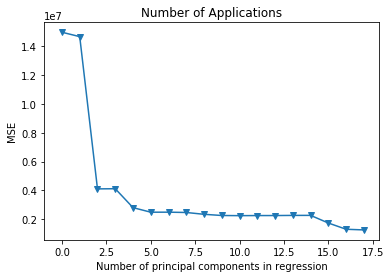

1266061.03687


In [526]:
# 10-fold CV, with shuffle
n = len(X_reduced)
kf_10 = KFold(n_splits=10, shuffle=True, random_state=1)

regr = LinearRegression()
mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*cross_val_score(regr, np.ones((n,1)), y.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using CV for the 19 principle components, adding one component at the time.
for i in np.arange(1, 18):
    score = -1*cross_val_score(regr, X_reduced[:,:i], y.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)
    
plt.plot(mse, '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Number of Applications')
plt.xlim(xmin=-1)
plt.show()
print(mse[-1])

The above plot indicates that the lowest training mean squared error is reached on all 17 components.

In [527]:
regr_test = LinearRegression()
regr_test.fit(X_reduced, y)
regr_test.coef_

array([  253.66931726,  1558.60007019,    11.47522826,  1189.07044066,
        -567.17300466,   -68.65997854,  -228.34365107,  -469.38040447,
        -446.56162148,   251.99849047,    41.23071509,   144.04806643,
          35.21546132,  -176.21947313,  2458.71599255,  2018.14055612,
        1469.96288483])

## Fitting PCA with training data

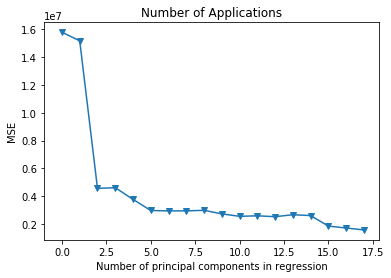

In [528]:
pca2 = PCA()
X_reduced_train = pca2.fit_transform(scale(X_train))
n = len(X_reduced_train)

# 10-fold CV, with shuffle
kf_10 = KFold(n_splits = 10, shuffle=True)

mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*cross_val_score(regr, np.ones((n,1)), y_train.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using CV for the 19 principle components, adding one component at the time.
for i in np.arange(1, 18):
    score = -1*cross_val_score(regr, X_reduced_train[:,:i], y_train.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)

plt.plot(np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Number of Applications')
plt.xlim(xmin=-1)
plt.show()

The above plot indicates that the lowest training MSE is found on regressing on all 17 components.  But this would be mean that there is no dimensionality reduction.  The calculation used is for both M = 17 and M = 15, because when M = 15, there will be some reduction taking place

In [529]:
X_reduced_test = pca2.transform(scale(X_test))[:,:16]

# Train regression model on training data 
regr = LinearRegression()
regr.fit(X_reduced_train[:,:16], y_train)

# Prediction with test data
pred = regr.predict(X_reduced_test)
print("MSE when M = 15: ", mean_squared_error(y_test, pred))

X_reduced_test = pca2.transform(scale(X_test))[:,:]

# Train regression model on training data 
regr = LinearRegression()
regr.fit(X_reduced_train[:,:], y_train)

# Prediction with test data
pred = regr.predict(X_reduced_test)
print("MSE when M = 17: ", mean_squared_error(y_test, pred))

('MSE when M = 15: ', 791250.060774385)
('MSE when M = 17: ', 756272.0853409929)


## Using Partial Least Squares

In [530]:
from sklearn.cross_decomposition import PLSRegression

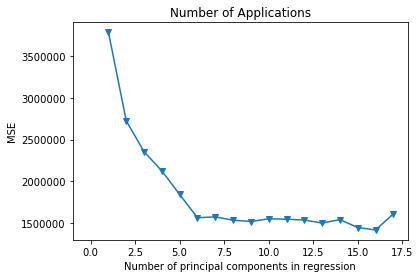

In [531]:
n = len(X_train)

# 10-fold CV, with shuffle
kf_10 = KFold(n_splits=10, shuffle=True)

mse = []

for i in np.arange(1, 18):
    pls = PLSRegression(n_components=i)
    score = -1*cross_val_score(pls, scale(X_train), y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)

plt.plot(np.arange(1, 18), np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Number of Applications')
plt.xlim(xmin=-1)
plt.show()

The above plot demonstrates that the least training MSE while using PLS can be used when doing regression on 9 components.

In [532]:
pls = PLSRegression(n_components=9)
pls.fit(scale(X_train), y_train)

mean_squared_error(y_test, pls.predict(scale(X_test)))

741776.98075556138